<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Device-Checks" data-toc-modified-id="Device-Checks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Device Checks</a></span></li><li><span><a href="#Environment-Set-up" data-toc-modified-id="Environment-Set-up-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Environment Set-up</a></span><ul class="toc-item"><li><span><a href="#Preprocessing-States" data-toc-modified-id="Preprocessing-States-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocessing States</a></span></li></ul></li><li><span><a href="#Experience-Replay" data-toc-modified-id="Experience-Replay-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Experience Replay</a></span></li><li><span><a href="#Double-Deep-Q-Learning-Agent" data-toc-modified-id="Double-Deep-Q-Learning-Agent-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Double Deep-Q-Learning Agent</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

## Device Checks

In [1]:
## CHECK AVAILABLE GPUs
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
## PRINT DEVICE DETAILS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6796392047585346306
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6428062074113815151
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6515012665
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11691378361202740259
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:07:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14000298869235200211
physical_device_desc: "device: XLA_GPU device"
]


## Environment Set-up

In [4]:
## IMPORT LIBRARIES
import gym
from gym import Wrapper
from gym import spaces
import retro

import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from PIL import Image

from collections import namedtuple, deque

import random

import tensorflow.keras as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import Huber

In [5]:
## INITIATE THE ENVIRONMENT
env = gym.make("SpaceInvaders-v0")

# Print environment details
print('State shape is {}\n'.format(env.observation_space.shape))
print('Possible actions are {}: '.format(env.action_space.n))
print(env.env.get_action_meanings())

State shape is (210, 160, 3)

Possible actions are 6: 
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


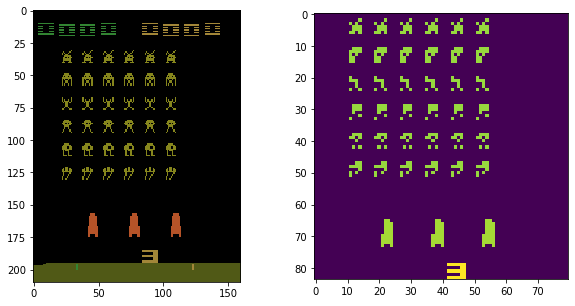

In [6]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
frame = env.reset()
plt.imshow(frame, interpolation='nearest')

plt.subplot(1,2,2)
frame = frame[28:196:2, ::2]
frame = frame.mean(axis=2)
frame = (frame - 128) / 128-1
plt.imshow(frame, interpolation='nearest')

### Preprocessing States

In [7]:
## CREATE A FUNCTION TO PREPROCESS STATES
def preprocess_state(state):
    """Reshape and transform an RGB state to grayscale"""
    # Crop unecessary lives & points pannel and resize the image
    state = state[28:196:2, ::2]
    # Convert the image to greyscale
    state = state.mean(axis=2)
    # Normalize the image from -1 to +1
    state = (state - 128) / 128-1
    return state.reshape(84,80)

## CREATE A CLASS THAT MODIFIES THE GYM ENVIRONMENT
class Environment(object):
    """Define environment parameters"""
    def __init__(self, env, stack=4):
        self.env = gym.make(env)
        self.stack = stack
        self.action_space = self.env.action_space
        self.actions = range(self.env.action_space.n)
        # Screen buffer of size 4 to be able to build state arrays of size [1, 4, 84, 80]
        self.state_buffer = deque()

    def reset(self):
        """Reshape a state into (84,80,1) and produce initial stacked state"""
        # Clear the state buffer
        self.state_buffer = deque()
        state = self.env.reset()
        state = preprocess_state(state)
        # Since new episode, copy the same frame 4x
        stacked_state = np.stack([state for i in range(self.stack)], axis=0)

        # Put first 3 frames in buffer
        for i in range(self.stack-1):
            self.state_buffer.append(state)
            
        return stacked_state
    
    def step(self, action_index):
        """Concatenate 3 previous states and current state to produce 
           a stacked state of shape (4,84,80)"""
        state, reward, done, info = self.env.step(self.actions[action_index])
        state = preprocess_state(state)
        
        previous_frames = np.array(self.state_buffer)
        stacked_state = np.empty((self.stack, 84, 80))
        stacked_state[:self.stack-1, :] = previous_frames
        stacked_state[self.stack-1] = state

        # Pop the oldest frame and add the current frame to the queue
        self.state_buffer.popleft()
        self.state_buffer.append(state)

        return stacked_state, reward, done, info
    
    def render(self):
        self.env.render()
        
    def close(self):
        self.env.close()

In [8]:
env = Environment("SpaceInvaders-v0",stack=4)
print('State shape is {}\n'.format(np.shape(env.reset())))
print('Possible actions are {}: '.format(env.action_space.n))
print(env.env.get_action_meanings())

State shape is (4, 84, 80)

Possible actions are 6: 
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


## Experience Replay

In [9]:
## CREATE A CLASS THAT STORES THE AGENT'S EXPERIENCES AND RETRIEVES RANDOM BATCHES FROM ITS MEMORY
class ReplayMemory:
    
    def __init__(self, capacity=10000, batch_size=32):
        """Define the class parameters"""
        self.capacity = capacity
        self.batch_size = batch_size
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

    def push(self, state, action, reward, next_state, done):
        """Add a new experience to the memory buffer"""
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def __len__(self):
        return len(self.buffer)        
        
    def sample(self):
        """Sample a random batch of experiences from the memory"""
        samples = random.sample(self.buffer, self.batch_size)

        states = np.array([state[0] for state in samples])
        actions = np.array([action[1] for action in samples])
        rewards = np.array([reward[2] for reward in samples])
        next_states = np.array([next_state[3] for next_state in samples])
        dones = np.array([done[4] for done in samples])
        
        return (states, actions, rewards, next_states, dones)
    


## Double Deep-Q-Learning Agent

In [10]:
## CREATE THE DOUBLE DEEP-Q-LEARNING AGENT
class DDQNAgent:

    def __init__(self, input_shape, action_space, capacity=10000, batch_size=32, memory_size=1000, 
                 learning_rate=0.00025, gamma = 0.99, epsilon=1.0, epsilon_min = 0.1, 
                 epsilon_decay = 0.9999):
        """Create an instance of a Deep-Q-Network Agent"""
        self.input_shape = input_shape
        self.action_size = action_space.n # number of possible actions
        self.learning_rate = learning_rate # model's learning rate
        self.gamma = gamma # discount rate
        self.batch_size = batch_size # size of batches sampled from memory
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min # threshold of epsilon
        self.epsilon_decay = epsilon_decay # decay of exploration rate
        self.model = self.build_model() # instance of dqn model
        self.target_model = self.build_model() # target model
        self.memory = ReplayMemory(capacity=capacity, batch_size=self.batch_size) # expirience replay memory
        self.memory_size = memory_size # threshold of memory size to start training
        
    def build_model(self):
        """Build the Convolutional DQN model"""
        model = Sequential()
        # add convolutional layers
        model.add(Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=self.input_shape,data_format='channels_first')) # provide as input shape the state shape
        model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
        model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
        model.add(Flatten())
        # add fully connected layers
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.action_size, activation='linear')) # provide as output the number of possible states
        # compile model with Huber loss and RMSprop optimizer
        model.compile(loss=Huber(), optimizer=Adam(lr=self.learning_rate))
        return model
    

    def get_action(self, state):
        """Select action according to the epsilon-greedy policy"""
        # get the correct dimension that the models accepts
        state = np.expand_dims(state, axis=0)
        action = self.model.predict(state)

        if random.random() > self.epsilon:
            return np.argmax(action[0]) # exploitation
        else:
            return random.choice(np.arange(self.action_size)) # exploration

    def train_model(self):
        """Train the model using random batches of experiences from the memory"""
        
        # start sampling from experience when memory is filled
        # pre-populate according to memory_size so that experiences are decorrelated to increase stability
        if len(self.memory) >= self.memory_size:
            states, actions, rewards, next_states, dones = self.memory.sample() # random memory sample
            # iterate over the batch to fix dimensions
            for i in range(len(states)):
                state, action, reward, next_state, done = states[i], actions[i], rewards[i], next_states[i], dones[i]
                state = np.expand_dims(state, axis=0)
                next_state = np.expand_dims(next_state, axis=0)
            
            targets = self.model.predict(states)
            target_next = self.model.predict(next_states) #DQN
            target_vals = self.target_model.predict(next_states) #Target model

            for i in range(self.batch_size):
                if dones[i]:
                    targets[i][actions[i]] = rewards[i]
                else:
                    # select an action using DQN model 
                    # update using the target model
                    a = np.argmax(target_next[i])
                    targets[i][actions[i]] = (rewards[i] + self.gamma * (target_vals[i][a]))

            
            # fit to get get the loss of the model
            loss = self.model.fit(states, targets, epochs=1, verbose=0).history['loss'][0]
            return loss
    
    def update_target_model(self):
        """Copy weights from the model used for action selection to the model used for computing targets"""
        self.target_model.set_weights(self.model.get_weights())
        
    def save_model(self):
        """Save the DQN Network"""
        self.model.save('spaceinv_local_model.h5')
        


In [11]:
# CREATE A RANDOM AGENT 
class RandomAgent:
    def __init__(self, action_space):
        """Create an instance of a random agent"""
        self.action_size = action_space.n
        
    def get_action(self):
        """Select action uniformly at random"""
        action = random.choice(np.arange(self.action_size))
        return action
    

## Training 

In [12]:
# INITIALIZE TRAINING PARAMETERS
EPISODES = 1000 # Number of episodes

cumulative_rewards = []

# Get an instance of a DDQN agent
ddqnAgent = DDQNAgent(np.shape(env.reset()),env.action_space, capacity=1000000, batch_size=64, memory_size=1000, 
                 learning_rate=0.00025, gamma = 0.99, epsilon=1.0, epsilon_min = 0.1, epsilon_decay = 0.9999)

In [13]:
## TRAIN THE DDQN AGENT
print('Training initialised...\n')
for episode in range(1, EPISODES+1):
    step = 0
    init_time = time()
    state = env.reset()
    C = 0.1*EPISODES # target update step
    ep_reward = 0
    done = False
    while not done:
        action = ddqnAgent.get_action(state)
        next_state, reward, done, info = env.step(action)
        ddqnAgent.memory.push(state, action, reward, next_state, done)
        ep_reward += reward

        if done:
            cumulative_rewards.append(ep_reward)
            if episode % C == 0:
                ddqnAgent.update_target_model()
            time_taken = time() - init_time # time taken to complete one episode                
            print('Episode {} of {}:\n   score: {} \n   loss: {} \n   \u03B5: {} \n   time taken: {:.3f} sec'.format(episode, EPISODES, ep_reward, loss, ddqnAgent.epsilon, time_taken))
            break
        else:
            if ddqnAgent.epsilon >= ddqnAgent.epsilon_min: 
                ddqnAgent.epsilon *= ddqnAgent.epsilon_decay # decaying exploration/exploitation
            
            state = next_state

            loss = ddqnAgent.train_model()
    
        
    # save best model so far
    if ep_reward == max(cumulative_rewards):
        ddqnAgent.save_model() 
    

        
print('\nTraining ended.')

Training initialised...

Episode 1 of 1000:
   score: 105.0 
   loss: None 
   ε: 0.9418558936958947 
   time taken: 15.463 sec
Episode 2 of 1000:
   score: 30.0 
   loss: 0.00014233113324735314 
   ε: 0.8914501632408608 
   time taken: 30.625 sec
Episode 3 of 1000:
   score: 135.0 
   loss: 0.11451184749603271 
   ε: 0.8385267419789821 
   time taken: 86.154 sec
Episode 4 of 1000:
   score: 120.0 
   loss: 0.00044425486703403294 
   ε: 0.790877863552439 
   time taken: 85.093 sec
Episode 5 of 1000:
   score: 120.0 
   loss: 0.008355343714356422 
   ε: 0.7379972423714398 
   time taken: 99.878 sec
Episode 6 of 1000:
   score: 185.0 
   loss: 0.00010772124369395897 
   ε: 0.6760288162188282 
   time taken: 128.509 sec
Episode 7 of 1000:
   score: 310.0 
   loss: 0.10146716982126236 
   ε: 0.6060304530186548 
   time taken: 158.829 sec
Episode 8 of 1000:
   score: 180.0 
   loss: 8.02075956016779e-05 
   ε: 0.5589310901060972 
   time taken: 117.668 sec
Episode 9 of 1000:
   score: 175.0

Episode 69 of 1000:
   score: 670.0 
   loss: 0.018519237637519836 
   ε: 0.0999969960769904 
   time taken: 194.755 sec
Episode 70 of 1000:
   score: 320.0 
   loss: 0.025096414610743523 
   ε: 0.0999969960769904 
   time taken: 163.722 sec
Episode 71 of 1000:
   score: 445.0 
   loss: 0.519556999206543 
   ε: 0.0999969960769904 
   time taken: 172.714 sec
Episode 72 of 1000:
   score: 220.0 
   loss: 3.3708995033521205e-05 
   ε: 0.0999969960769904 
   time taken: 130.123 sec
Episode 73 of 1000:
   score: 165.0 
   loss: 0.05049552768468857 
   ε: 0.0999969960769904 
   time taken: 119.469 sec
Episode 74 of 1000:
   score: 255.0 
   loss: 0.07822874933481216 
   ε: 0.0999969960769904 
   time taken: 167.732 sec
Episode 75 of 1000:
   score: 275.0 
   loss: 7.410949910990894e-05 
   ε: 0.0999969960769904 
   time taken: 109.893 sec
Episode 76 of 1000:
   score: 145.0 
   loss: 0.012329247780144215 
   ε: 0.0999969960769904 
   time taken: 97.895 sec
Episode 77 of 1000:
   score: 95.0 

Episode 137 of 1000:
   score: 145.0 
   loss: 0.08850693702697754 
   ε: 0.0999969960769904 
   time taken: 103.609 sec
Episode 138 of 1000:
   score: 285.0 
   loss: 0.03773989528417587 
   ε: 0.0999969960769904 
   time taken: 150.227 sec
Episode 139 of 1000:
   score: 130.0 
   loss: 0.02471611648797989 
   ε: 0.0999969960769904 
   time taken: 96.335 sec
Episode 140 of 1000:
   score: 110.0 
   loss: 3.697690408444032e-05 
   ε: 0.0999969960769904 
   time taken: 90.644 sec
Episode 141 of 1000:
   score: 100.0 
   loss: 1.7202779417857528e-05 
   ε: 0.0999969960769904 
   time taken: 90.831 sec
Episode 142 of 1000:
   score: 320.0 
   loss: 5.047464219387621e-05 
   ε: 0.0999969960769904 
   time taken: 144.310 sec
Episode 143 of 1000:
   score: 140.0 
   loss: 0.03776083141565323 
   ε: 0.0999969960769904 
   time taken: 79.501 sec
Episode 144 of 1000:
   score: 180.0 
   loss: 0.03776555135846138 
   ε: 0.0999969960769904 
   time taken: 112.385 sec
Episode 145 of 1000:
   score

Episode 205 of 1000:
   score: 345.0 
   loss: 1.4411808479053434e-05 
   ε: 0.0999969960769904 
   time taken: 122.432 sec
Episode 206 of 1000:
   score: 305.0 
   loss: 2.3123478968045674e-05 
   ε: 0.0999969960769904 
   time taken: 149.913 sec
Episode 207 of 1000:
   score: 225.0 
   loss: 3.083654155489057e-05 
   ε: 0.0999969960769904 
   time taken: 136.734 sec
Episode 208 of 1000:
   score: 400.0 
   loss: 3.793388168560341e-05 
   ε: 0.0999969960769904 
   time taken: 217.428 sec
Episode 209 of 1000:
   score: 490.0 
   loss: 9.484696056460962e-05 
   ε: 0.0999969960769904 
   time taken: 190.125 sec
Episode 210 of 1000:
   score: 185.0 
   loss: 0.07544473558664322 
   ε: 0.0999969960769904 
   time taken: 86.564 sec
Episode 211 of 1000:
   score: 425.0 
   loss: 3.349378675920889e-05 
   ε: 0.0999969960769904 
   time taken: 209.258 sec
Episode 212 of 1000:
   score: 135.0 
   loss: 9.31239701458253e-05 
   ε: 0.0999969960769904 
   time taken: 85.913 sec
Episode 213 of 1000

Episode 273 of 1000:
   score: 120.0 
   loss: 0.037736330181360245 
   ε: 0.0999969960769904 
   time taken: 74.701 sec
Episode 274 of 1000:
   score: 495.0 
   loss: 2.876875441870652e-05 
   ε: 0.0999969960769904 
   time taken: 201.756 sec
Episode 275 of 1000:
   score: 345.0 
   loss: 0.036403656005859375 
   ε: 0.0999969960769904 
   time taken: 147.726 sec
Episode 276 of 1000:
   score: 470.0 
   loss: 0.07544592767953873 
   ε: 0.0999969960769904 
   time taken: 144.657 sec
Episode 277 of 1000:
   score: 165.0 
   loss: 0.011718288995325565 
   ε: 0.0999969960769904 
   time taken: 86.718 sec
Episode 278 of 1000:
   score: 35.0 
   loss: 0.050755247473716736 
   ε: 0.0999969960769904 
   time taken: 76.038 sec
Episode 279 of 1000:
   score: 185.0 
   loss: 0.011708986014127731 
   ε: 0.0999969960769904 
   time taken: 109.648 sec
Episode 280 of 1000:
   score: 255.0 
   loss: 1.7988959370995872e-05 
   ε: 0.0999969960769904 
   time taken: 150.169 sec
Episode 281 of 1000:
   sc

Episode 341 of 1000:
   score: 50.0 
   loss: 0.011701053008437157 
   ε: 0.0999969960769904 
   time taken: 54.949 sec
Episode 342 of 1000:
   score: 330.0 
   loss: 0.12621381878852844 
   ε: 0.0999969960769904 
   time taken: 173.683 sec
Episode 343 of 1000:
   score: 395.0 
   loss: 0.12623947858810425 
   ε: 0.0999969960769904 
   time taken: 151.350 sec
Episode 344 of 1000:
   score: 85.0 
   loss: 3.488718357402831e-05 
   ε: 0.0999969960769904 
   time taken: 99.742 sec
Episode 345 of 1000:
   score: 470.0 
   loss: 0.011696632020175457 
   ε: 0.0999969960769904 
   time taken: 210.522 sec
Episode 346 of 1000:
   score: 180.0 
   loss: 3.005152211699169e-05 
   ε: 0.0999969960769904 
   time taken: 142.372 sec
Episode 347 of 1000:
   score: 175.0 
   loss: 2.2122640075394884e-05 
   ε: 0.0999969960769904 
   time taken: 118.954 sec
Episode 348 of 1000:
   score: 450.0 
   loss: 6.271030542848166e-06 
   ε: 0.0999969960769904 
   time taken: 184.219 sec
Episode 349 of 1000:
   s

Episode 409 of 1000:
   score: 215.0 
   loss: 0.037764523178339005 
   ε: 0.0999969960769904 
   time taken: 167.938 sec
Episode 410 of 1000:
   score: 410.0 
   loss: 0.036417748779058456 
   ε: 0.0999969960769904 
   time taken: 159.433 sec
Episode 411 of 1000:
   score: 185.0 
   loss: 0.0001154988567577675 
   ε: 0.0999969960769904 
   time taken: 128.460 sec
Episode 412 of 1000:
   score: 465.0 
   loss: 4.529578291112557e-05 
   ε: 0.0999969960769904 
   time taken: 268.834 sec
Episode 413 of 1000:
   score: 335.0 
   loss: 4.147551953792572e-05 
   ε: 0.0999969960769904 
   time taken: 197.372 sec
Episode 414 of 1000:
   score: 145.0 
   loss: 1.1016578355338424e-05 
   ε: 0.0999969960769904 
   time taken: 110.948 sec
Episode 415 of 1000:
   score: 240.0 
   loss: 0.08714748173952103 
   ε: 0.0999969960769904 
   time taken: 198.601 sec
Episode 416 of 1000:
   score: 125.0 
   loss: 0.10148084908723831 
   ε: 0.0999969960769904 
   time taken: 159.844 sec
Episode 417 of 1000:


Episode 477 of 1000:
   score: 385.0 
   loss: 0.01168995350599289 
   ε: 0.0999969960769904 
   time taken: 152.094 sec
Episode 478 of 1000:
   score: 155.0 
   loss: 2.4339733499800786e-05 
   ε: 0.0999969960769904 
   time taken: 117.175 sec
Episode 479 of 1000:
   score: 295.0 
   loss: 0.024720152840018272 
   ε: 0.0999969960769904 
   time taken: 173.209 sec
Episode 480 of 1000:
   score: 160.0 
   loss: 0.02471994422376156 
   ε: 0.0999969960769904 
   time taken: 117.743 sec
Episode 481 of 1000:
   score: 175.0 
   loss: 1.0037796528195031e-05 
   ε: 0.0999969960769904 
   time taken: 134.532 sec
Episode 482 of 1000:
   score: 405.0 
   loss: 0.011689068749547005 
   ε: 0.0999969960769904 
   time taken: 222.912 sec
Episode 483 of 1000:
   score: 100.0 
   loss: 6.19770571574918e-06 
   ε: 0.0999969960769904 
   time taken: 124.725 sec
Episode 484 of 1000:
   score: 290.0 
   loss: 0.06251738965511322 
   ε: 0.0999969960769904 
   time taken: 244.807 sec
Episode 485 of 1000:
  

KeyboardInterrupt: 

## Evaluation

Text(0.5, 1.0, 'Cumulative Reward per Episode')

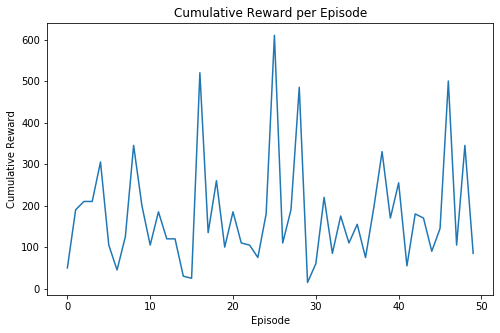

In [13]:
# PLOT TIME-PROGRESSION INDEX
plt.figure(figsize=(8,5))

# Cumulative Reward per episode
plt.plot(cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward per Episode')


In [16]:
## EVALUATE THE TRAINED DDQN AGENT AGAINST A RANDOM AGENT
saved_model = 'spaceinv_local_model.h5'
DDQN_score = []
test_agent = load_model(saved_model)
RAND_score = []
RAND_agent = RandomAgent(env.action_space)
runs = 1

# Run the trained agent for one episode
for run in range(1,runs+1):
    state = env.reset()
    state = np.expand_dims(state, axis=0)
    ep_reward = 0
    done = False
    while not done:
        action = test_agent.predict(state)
        a = np.argmax(action[0])
        env.render()
        next_state, reward, done, info = env.step(a)
        ep_reward += reward
        state = next_state
        state = np.expand_dims(state, axis=0)
    DDQN_score.append(ep_reward)    
    env.close()

# Run the random agent for one episode
for run in range(1,runs+1):
    state = env.reset()
    ep_reward = 0
    done = False
    while not done:
        action = RAND_agent.get_action()
        env.render()
        next_state, reward, done, info = env.step(action)
        ep_reward += reward
        state = next_state
    RAND_score.append(ep_reward)    
    env.close()

print('Trained agent score: {}, Random agent score: {}'.format(DDQN_score,RAND_score))

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
